# Count Clashes

How do the number of clashes vary with the number of simulation snapshots?

#### Import Modules

In [1]:
import os
import numpy as np
import pandas as pd
from itertools import groupby
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import wlcstat.chromo

#### Specify Output Directory

In [2]:
out_dir = "/home/users/jwakim/chromo_variable_linkers/output_10"
sims = os.listdir(out_dir)
sims = [sim for sim in sims if sim.startswith("sim_") and os.path.isdir(os.path.join(out_dir, sim))]
sim_inds = [int(sim.split("_")[-1]) for sim in sims]

# Temp: Isolate the latest snapshot
sims = [sims[np.argmax(sim_inds)]]

#### In Each Simulation Count the Number of Steric Clashes

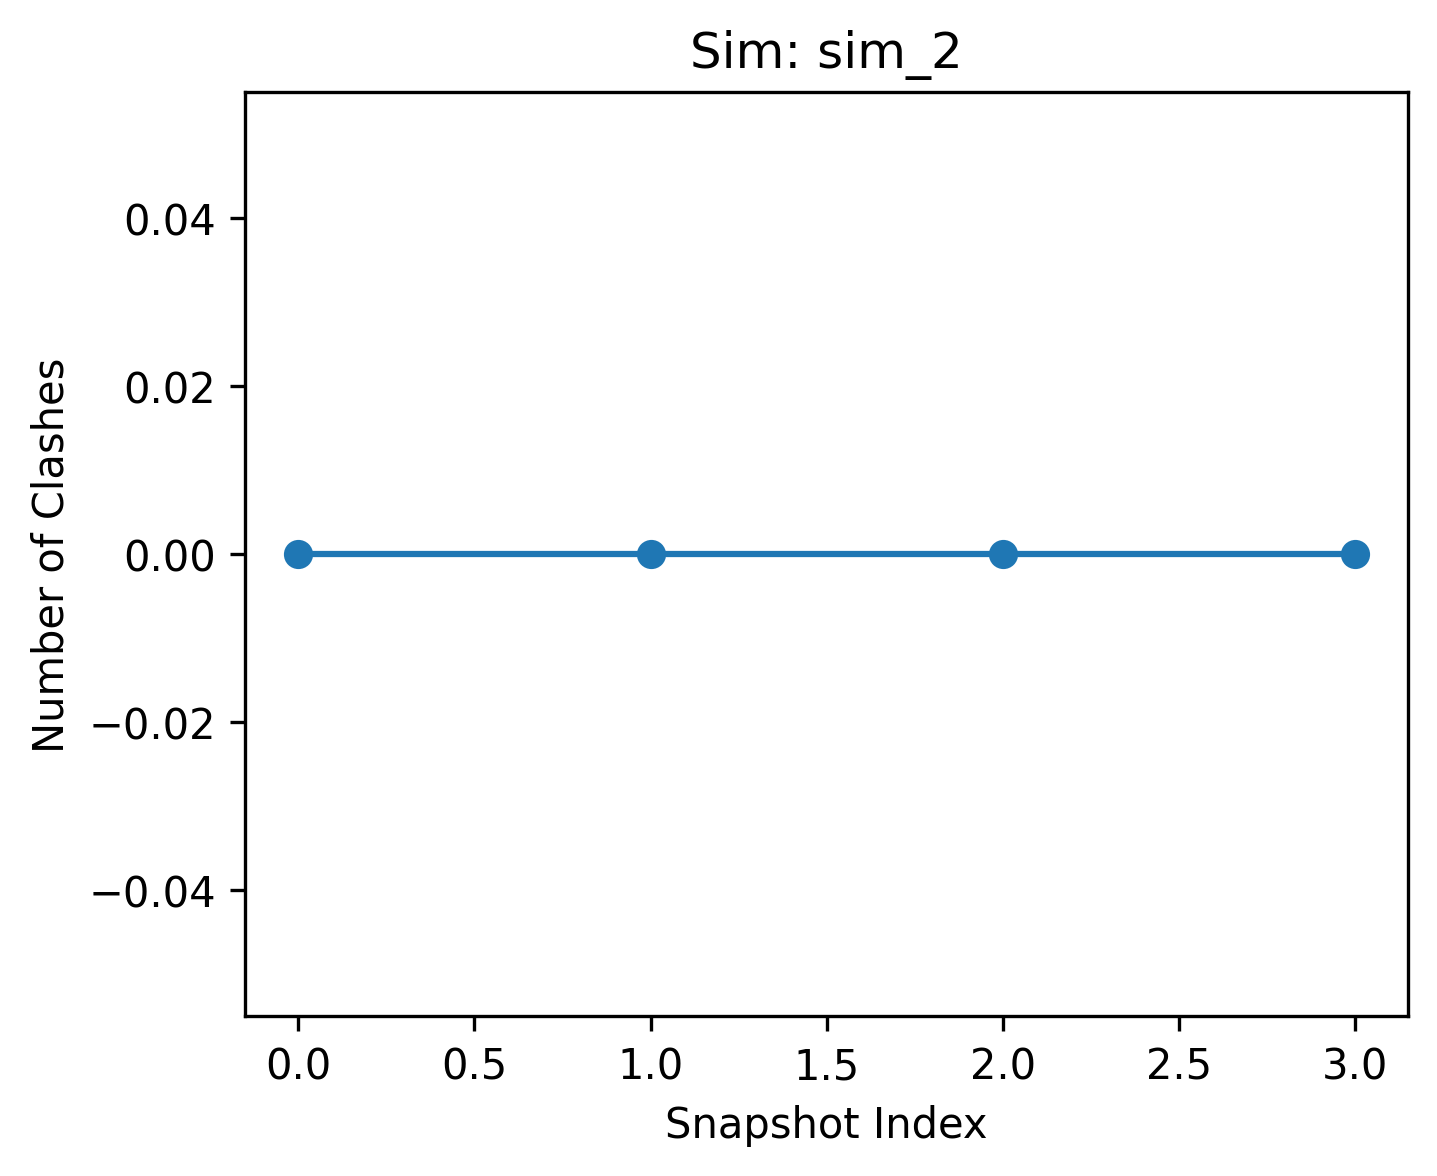

In [3]:
nucleosome_radius = 4.1899999999999995
cutoff_dist = 2 * nucleosome_radius

for sim in sims:
    
    # Identify snapshots
    sim_dir = os.path.join(out_dir, sim)
    snaps = os.listdir(sim_dir)
    snaps = [snap for snap in snaps if snap.startswith("Chr") and snap.endswith(".csv")]
    snap_inds = [int(snap.split("-")[-1].split(".")[0]) for snap in snaps]
    snaps = [snap for _, snap in sorted(zip(snap_inds, snaps))]
    snap_inds = np.sort(snap_inds)
    latest_snap = snaps[np.argmax(snap_inds)]

    # Insert the initial configuration into the list
    snaps.insert(0, "Chr")
    snap_inds += 1
    ind_to_add = np.array([0])
    snap_inds = np.concatenate((ind_to_add, snap_inds))

    n_clashes_lst = []
    for snap in snaps:
        # Load latest configuration
        r = pd.read_csv(os.path.join(sim_dir, snap), header=[0, 1], index_col=0)["r"].to_numpy()
    
        # compute pairwise distances
        N = len(r)
        pairwise_dist = np.zeros((N, N))
        for i in range(N):
            for j in range(i, N):
                if i == j:
                    # Set the diagonal to infinity
                    pairwise_dist[i, j] = np.inf
                else:
                    # Compute the Euclidean distance
                    pairwise_dist[i, j] = np.linalg.norm(r[i] - r[j])
                pairwise_dist[j, i] = pairwise_dist[i, j]
        
        # Identify clashes
        clashes = (pairwise_dist < cutoff_dist)
        n_clash = np.sum(clashes) / 2
        n_clashes_lst.append(n_clash)

    for i in range(1, len(n_clashes_lst)):
        assert n_clashes_lst[i] <= n_clashes_lst[i-1], "Number of clashes should not increase."

    plt.figure(figsize=(5,4), dpi=300)
    plt.plot(snap_inds, n_clashes_lst, "o-")
    plt.xlabel("Snapshot Index")
    plt.ylabel("Number of Clashes")
    plt.title(f"Sim: {sim}")
    plt.show()

#### Evaluate Cluster Size Distribution

In [4]:
def identify_clusters(linker_lengths, min_count=4, cutoff=15):
    """Identify clusters of compacted nucleosomes based on linker lengths.
    """
    
    # Identify if nucleosomes are in interacting distance
    gamma = (linker_lengths < cutoff).astype(int)

    # Group `gamma` into sets of equivalent values
    adjacent_sets = groupby(gamma)

    # Characterize the sets
    set_types = {}
    set_sizes = {}
    bead_set_map = {}
    set_bead_map = {}
    index = 0
    for i, (key, group) in enumerate(adjacent_sets):
        set_types[i] = key
        set_size = len(list(group))
        set_sizes[i] = set_size
        set_bead_map[i] = []
        for bead in range(index, index+set_size):
            bead_set_map[bead] = i
            set_bead_map[i].append(bead)
        index += set_size

    # Identify clusters (sets of type `1` with size >= 4)
    n_sets = len(list(set_types.keys()))
    clusters = [
        i for i in range(n_sets)
        if (set_types[i] == 1) and (set_sizes[i] >= min_count)
    ]

    # Identify nucleosomes in each cluster
    cluster_inds = {cluster: set_bead_map[cluster] for cluster in clusters}
    
    return cluster_inds

In [5]:
def radius_of_gyration(coordinates):
    """Calculate the radius of gyration for a set of coordinates.
    """
    center_of_mass = np.mean(coordinates, axis=0)
    displacement_vectors = coordinates - center_of_mass
    squared_distances = np.sum(displacement_vectors ** 2, axis=1)
    rg_squared = np.mean(squared_distances)
    rg = np.sqrt(rg_squared)
    return rg


def minor_radius_of_gyration(coordinates):
    """Calculate the minor component of the radius of gyration.
    """

    # Project points onto xy, xz, yz planes
    projection_inds = [[0, 1], [0, 2], [1, 2]]
    all_radii = []
    for projection in projection_inds:

        # Project all points onto x, y plane
        coordinates_ = coordinates[:, projection]

        # Compute the center of mass
        center_of_mass = np.mean(coordinates_, axis=0)

        # Compute the Rg tensor
        # The block below can be made more efficient using np.einsum...
        # But I am electing for interpretability over a slight speed boost
        N = len(coordinates_)
        delta_vec = (coordinates_[0] - center_of_mass)
        Rg_tensor = np.outer(delta_vec, delta_vec)
        assert np.allclose(Rg_tensor.shape, (2, 2)), \
            "Rg tensor is incorrect shape."
        for i in range(1, N):
            delta_vec = (coordinates_[i] - center_of_mass)
            Rg_tensor += np.outer(delta_vec, delta_vec)
        Rg_tensor /= N

        # Compute the eigenvalues of the Rg tensor
        eigenvalues = np.linalg.eigvals(Rg_tensor)

        # Return the minor radius (obtained from the second eigenvalue)
        minor_radius = np.sqrt(eigenvalues[-1])
        all_radii.append(minor_radius)
    return all_radii

In [6]:
# Load Linker Length Profile
links_path = "/home/users/jwakim/chromo_variable_linkers/simulations/examples/example_links_mu_m9p76_mark_0p05.csv"
links = np.loadtxt(links_path)
assert len(links) == 200
links = links[:len(r) - 1]

In [7]:
# Identify clusters
cluster_inds = identify_clusters(links)

# Load the radius of gyration for each cluster
all_Rg = []
all_minor_Rg = []
n_equilibrate = 200

for cluster_id, inds in cluster_inds.items():
    for sim in sims:
    
        # Identify snapshots
        sim_dir = os.path.join(out_dir, sim)
        snaps = os.listdir(sim_dir)
        snaps = [snap for snap in snaps if snap.startswith("Chr") and snap.endswith(".csv")]
        snap_inds = [int(snap.split("-")[-1].split(".")[0]) for snap in snaps]
        snaps = [snap for _, snap in sorted(zip(snap_inds, snaps))]
        snap_inds = np.sort(snap_inds)
        latest_snap = snaps[np.argmax(snap_inds)]
        snaps_equilibrated = snaps[-n_equilibrate:]

        for snap in snaps_equilibrated:
            
            # Load configuration
            r = pd.read_csv(os.path.join(sim_dir, snap), header=[0, 1], index_col=0)["r"].to_numpy()

            # Generate cluster size
            Rg = radius_of_gyration(r[inds])
            Rg_minor = minor_radius_of_gyration(r[inds])

            # Store the cluster size
            all_Rg.append(Rg)
            all_minor_Rg.append(Rg_minor)
            
all_minor_Rg = np.array(all_minor_Rg).flatten()
all_Rg = np.array(all_Rg).flatten()

In [8]:
# Plot Cluster Sizes
bin_edges = [5, 12, 24, 36, 48]
labels = ["5-12", "12-24", "24-36", "36-48"]

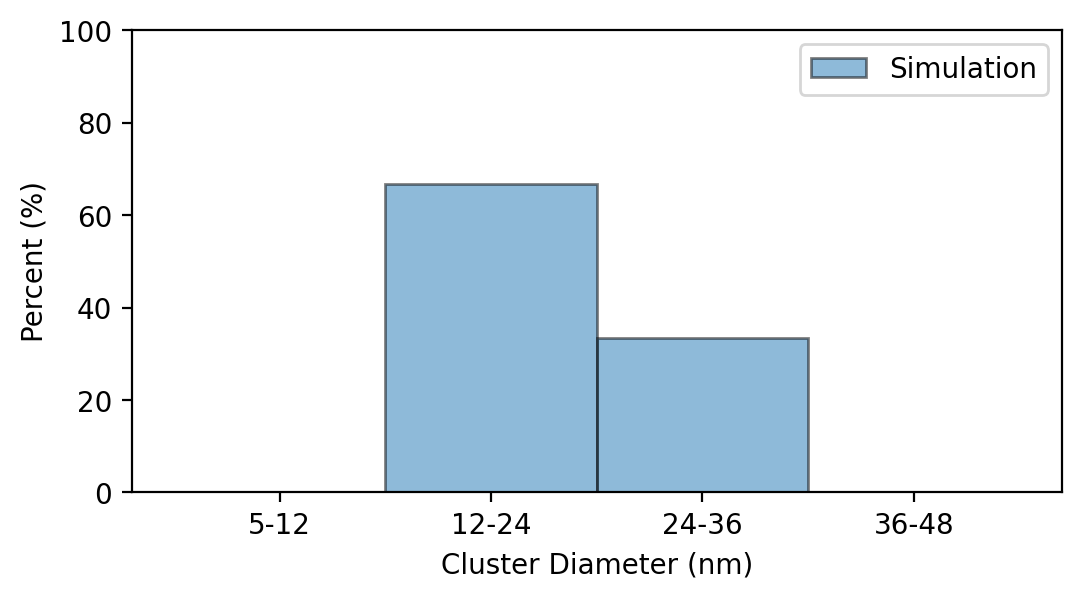

In [9]:
diameters = np.array(all_Rg) * 2

# Use numpy's histogram function to get bin counts and edges
counts, edges = np.histogram(diameters, bins=bin_edges)
x_temp = np.arange(len(counts))
counts = counts.astype(float) / np.sum(counts) * 100

plt.figure(figsize=(6,3), dpi=200)
plt.bar(x_temp, counts, width=1, edgecolor='black', alpha=0.5, label="Simulation")
plt.xlabel("Cluster Diameter (nm)")
plt.ylabel("Percent (%)")
plt.xticks(x_temp, labels)
plt.legend()
plt.ylim((0, 100))
plt.show()

/tmp/ipykernel_187492/412968515.py:6: RuntimeWarning: invalid value encountered in true_divide
  counts = counts.astype(float) / np.sum(counts) * 100


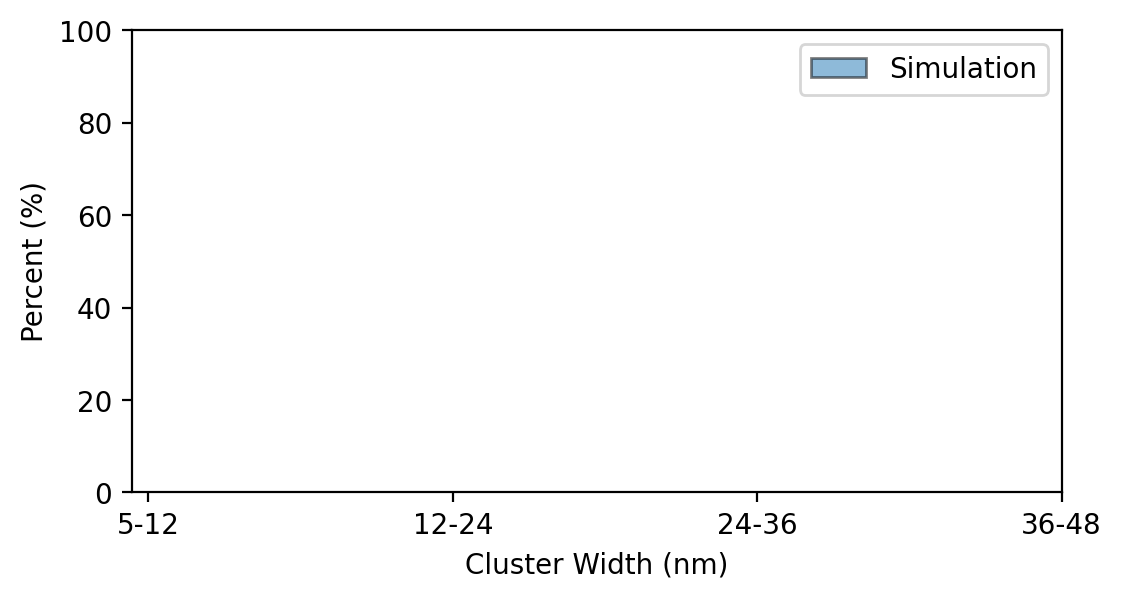

In [10]:
diameters = np.array(all_minor_Rg) * 2

# Use numpy's histogram function to get bin counts and edges
counts, edges = np.histogram(diameters, bins=bin_edges)
x_temp = np.arange(len(counts))
counts = counts.astype(float) / np.sum(counts) * 100

plt.figure(figsize=(6,3), dpi=200)
plt.bar(x_temp, counts, width=1, edgecolor='black', alpha=0.5, label="Simulation")
plt.xlabel("Cluster Width (nm)")
plt.ylabel("Percent (%)")
plt.xticks(x_temp, labels)
plt.legend()
plt.ylim((0, 100))
plt.show()

In [11]:
# Generate equivalent configurations with chain growth model
n_realizations = 3
all_Rg_chain_growth = []
all_minor_Rg_chain_growth = []
for _ in range(n_realizations):
    _, _, _, rn, _ = wlcstat.chromo.gen_chromo_conf(links.astype(int))

    for cluster_id, inds in cluster_inds.items():
        rn_cluster = rn[inds]
        Rg = radius_of_gyration(rn_cluster)
        Rg_minor = minor_radius_of_gyration(rn_cluster)
        all_Rg_chain_growth.append(Rg)
        all_minor_Rg_chain_growth.append(Rg_minor)

all_minor_Rg_chain_growth = np.array(all_minor_Rg_chain_growth).flatten()
all_Rg_chain_growth = np.array(all_Rg_chain_growth).flatten()

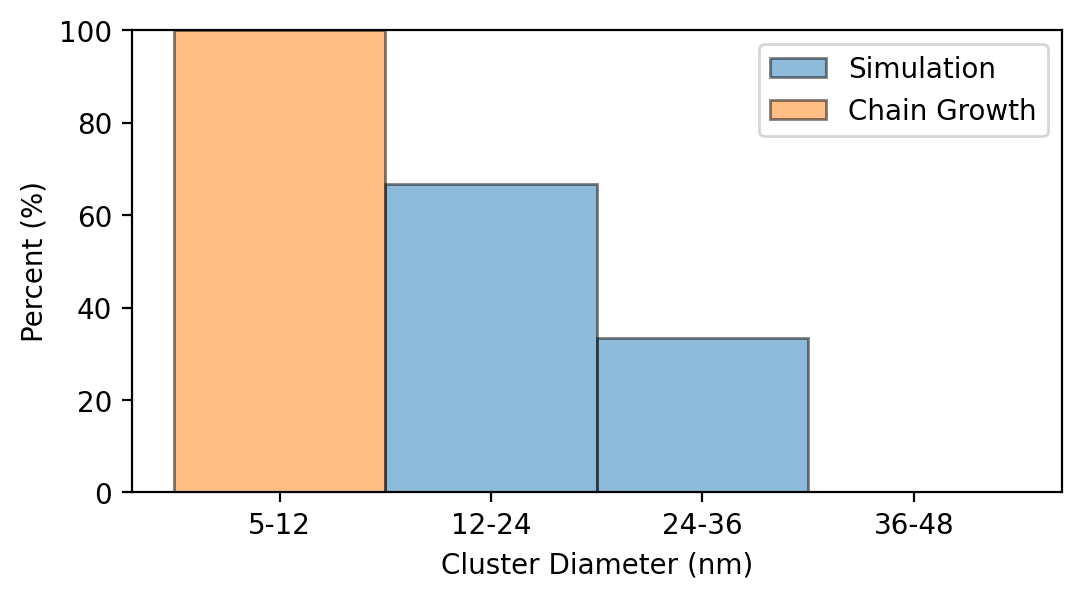

In [12]:
diameters = np.array(all_Rg) * 2
diameters_chain_growth = np.array(all_Rg_chain_growth) * 2

# Use numpy's histogram function to get bin counts and edges
counts, edges = np.histogram(diameters, bins=bin_edges)
x_temp = np.arange(len(counts))
counts = counts.astype(float) / np.sum(counts) * 100

# Use numpy's histogram function to get bin counts and edges
counts_chain_growth, edges_chain_growth = np.histogram(diameters_chain_growth, bins=bin_edges)
x_temp_chain_growth = np.arange(len(counts_chain_growth))
counts_chain_growth = counts_chain_growth.astype(float) / np.sum(counts_chain_growth) * 100

plt.figure(figsize=(6,3), dpi=200)
plt.bar(x_temp, counts, width=1, edgecolor='black', alpha=0.5, label="Simulation")
plt.bar(x_temp_chain_growth, counts_chain_growth, width=1, edgecolor='black', alpha=0.5, label="Chain Growth")
plt.xlabel("Cluster Diameter (nm)")
plt.ylabel("Percent (%)")
plt.xticks(x_temp, labels)
plt.legend()
plt.ylim((0, 100))
plt.show()

/tmp/ipykernel_187492/917227138.py:7: RuntimeWarning: invalid value encountered in true_divide
  counts = counts.astype(float) / np.sum(counts) * 100


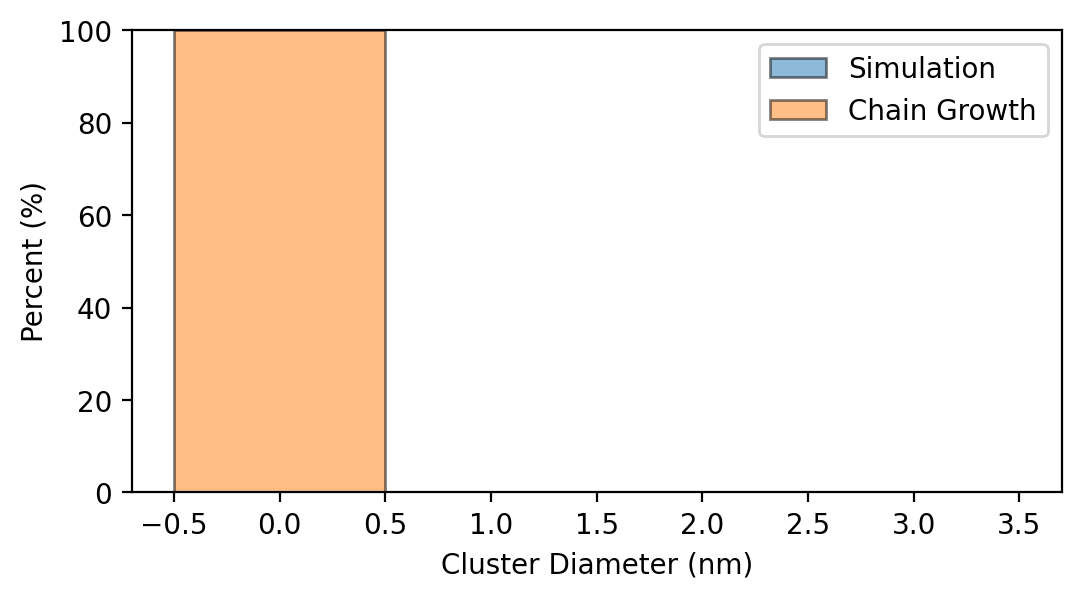

In [13]:
diameters = np.array(all_minor_Rg) * 2
diameters_chain_growth = np.array(all_minor_Rg_chain_growth) * 2

# Use numpy's histogram function to get bin counts and edges
counts, edges = np.histogram(diameters, bins=bin_edges)
x_temp = np.arange(len(counts))
counts = counts.astype(float) / np.sum(counts) * 100

# Use numpy's histogram function to get bin counts and edges
counts_chain_growth, edges_chain_growth = np.histogram(diameters_chain_growth, bins=bin_edges)
x_temp_chain_growth = np.arange(len(counts_chain_growth))
counts_chain_growth = counts_chain_growth.astype(float) / np.sum(counts_chain_growth) * 100

plt.figure(figsize=(6,3), dpi=200)
plt.bar(x_temp, counts, width=1, edgecolor='black', alpha=0.5, label="Simulation")
plt.bar(x_temp_chain_growth, counts_chain_growth, width=1, edgecolor='black', alpha=0.5, label="Chain Growth")
plt.xlabel("Cluster Diameter (nm)")
plt.ylabel("Percent (%)")
plt.legend()
plt.ylim((0, 100))
plt.show()

The simulation appears to form larger clusters than the chain growth model. Why does this seem to be the case? For one thing, we expect steric interactions to increse the mean cluster size. This is inevitable, given that the chain growth algorithm does not account for steric interactions and produces overlapping nucleosomes. Let's look at a more precise distribution of cluster sizes to inspect this further.

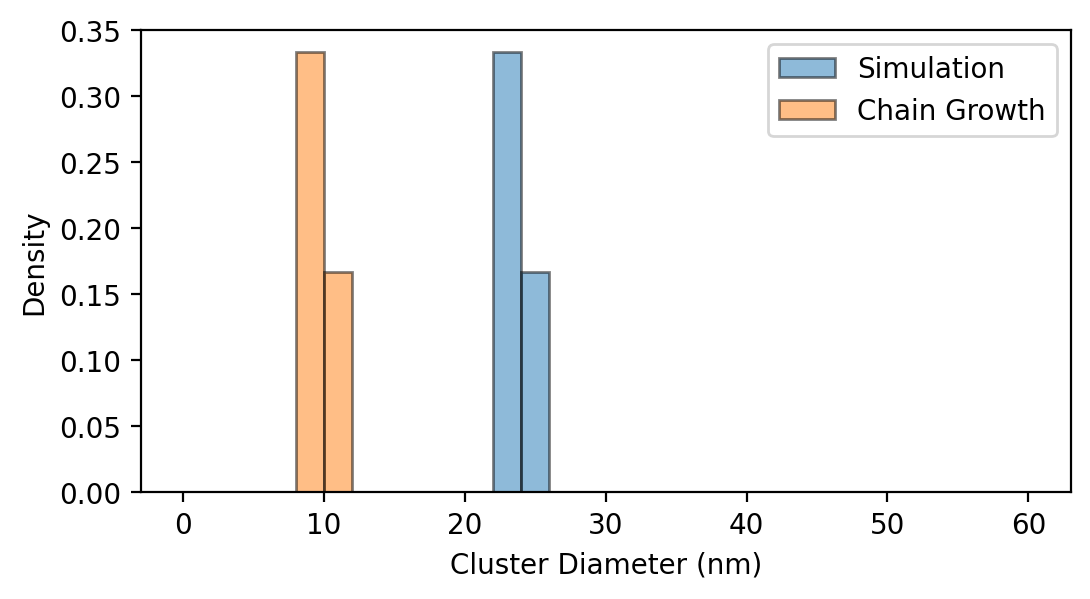

In [14]:
diameters = np.array(all_Rg) * 2
diameters_chain_growth = np.array(all_Rg_chain_growth) * 2
bin_edges = np.linspace(0, 60, 31)

plt.figure(figsize=(6,3), dpi=200)
plt.hist(diameters, bins=bin_edges, edgecolor='black', alpha=0.5, density=True, label="Simulation")
plt.hist(diameters_chain_growth, bins=bin_edges, edgecolor='black', alpha=0.5, density=True, label="Chain Growth")
plt.xlabel("Cluster Diameter (nm)")
plt.ylabel("Density")
plt.legend()
plt.show()

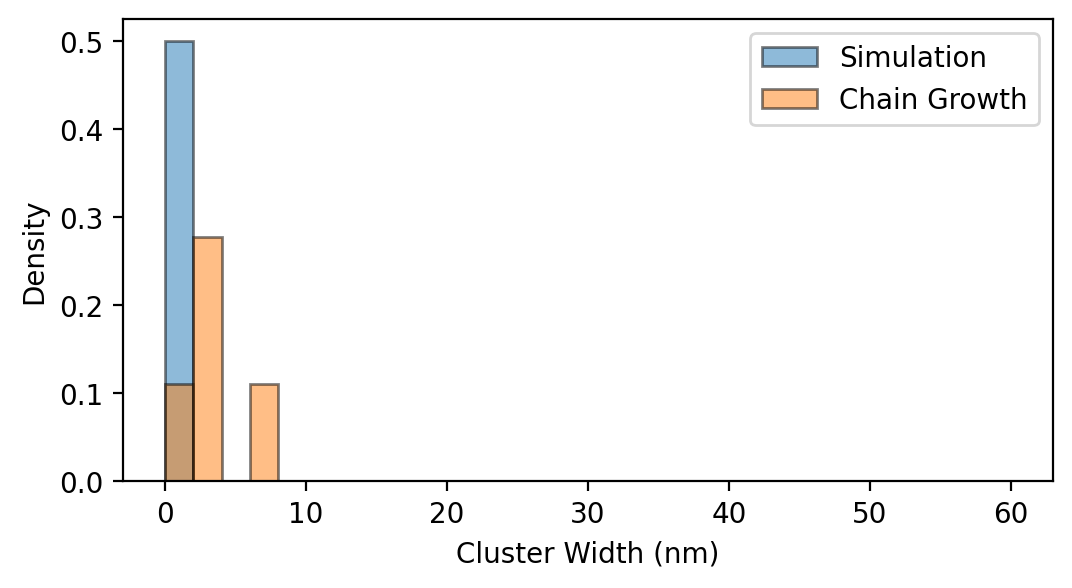

In [15]:
diameters = np.array(all_minor_Rg) * 2
diameters_chain_growth = np.array(all_minor_Rg_chain_growth) * 2
bin_edges = np.linspace(0, 60, 31)

plt.figure(figsize=(6,3), dpi=200)
plt.hist(diameters, bins=bin_edges, edgecolor='black', alpha=0.5, density=True, label="Simulation")
plt.hist(diameters_chain_growth, bins=bin_edges, edgecolor='black', alpha=0.5, density=True, label="Chain Growth")
plt.xlabel("Cluster Width (nm)")
plt.ylabel("Density")
plt.legend()
plt.show()

There is a notable rightward shift in the cluster size distribution with the introduction of steric interactions. How do we account for this? Let's start by visualizing a simulated configurations.

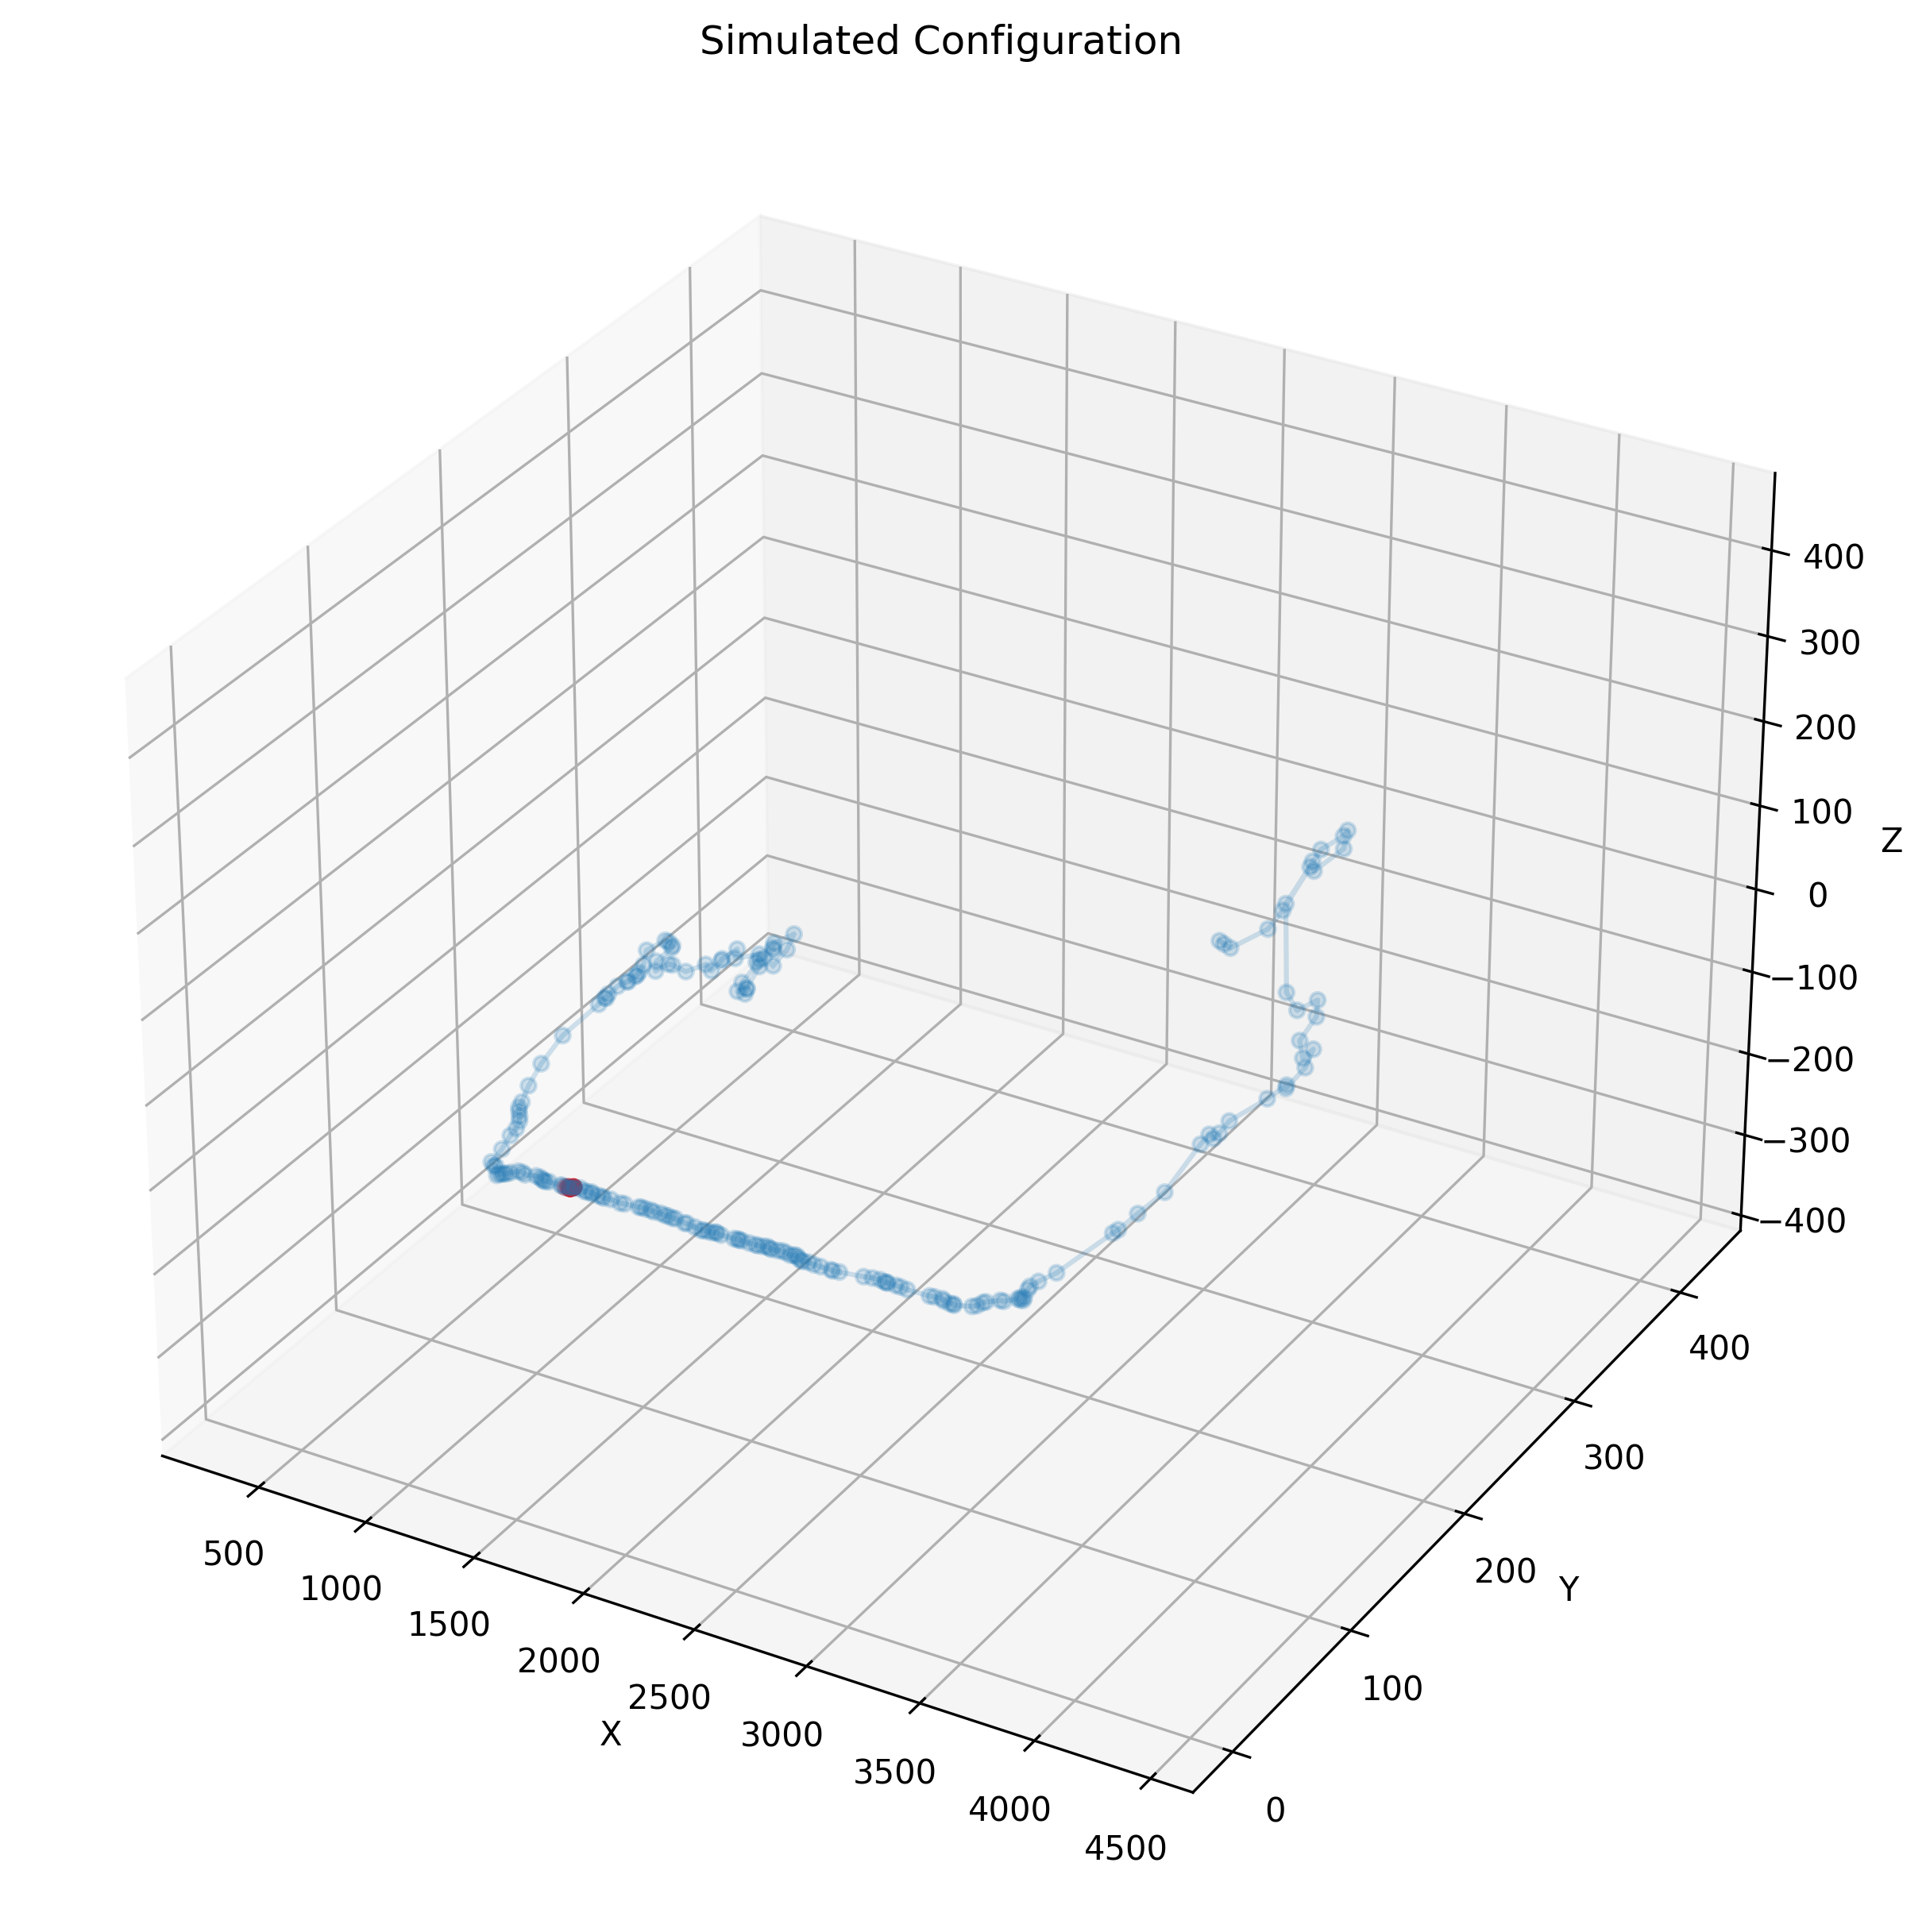

In [16]:
x = r[:, 0]
y = r[:, 1]
z = r[:, 2]

fig = plt.figure(figsize=(10, 10), dpi=300)
ax = fig.add_subplot(111, projection='3d')

# Plot the points
ax.scatter(x, y, z, alpha=0.2)
ax.scatter(x[inds], y[inds], z[inds], color="Red")
ax.plot(x, y, z, alpha=0.2)
ax.plot(x[inds], y[inds], z[inds], color="Red")

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Simulated Configuration')

plt.show()

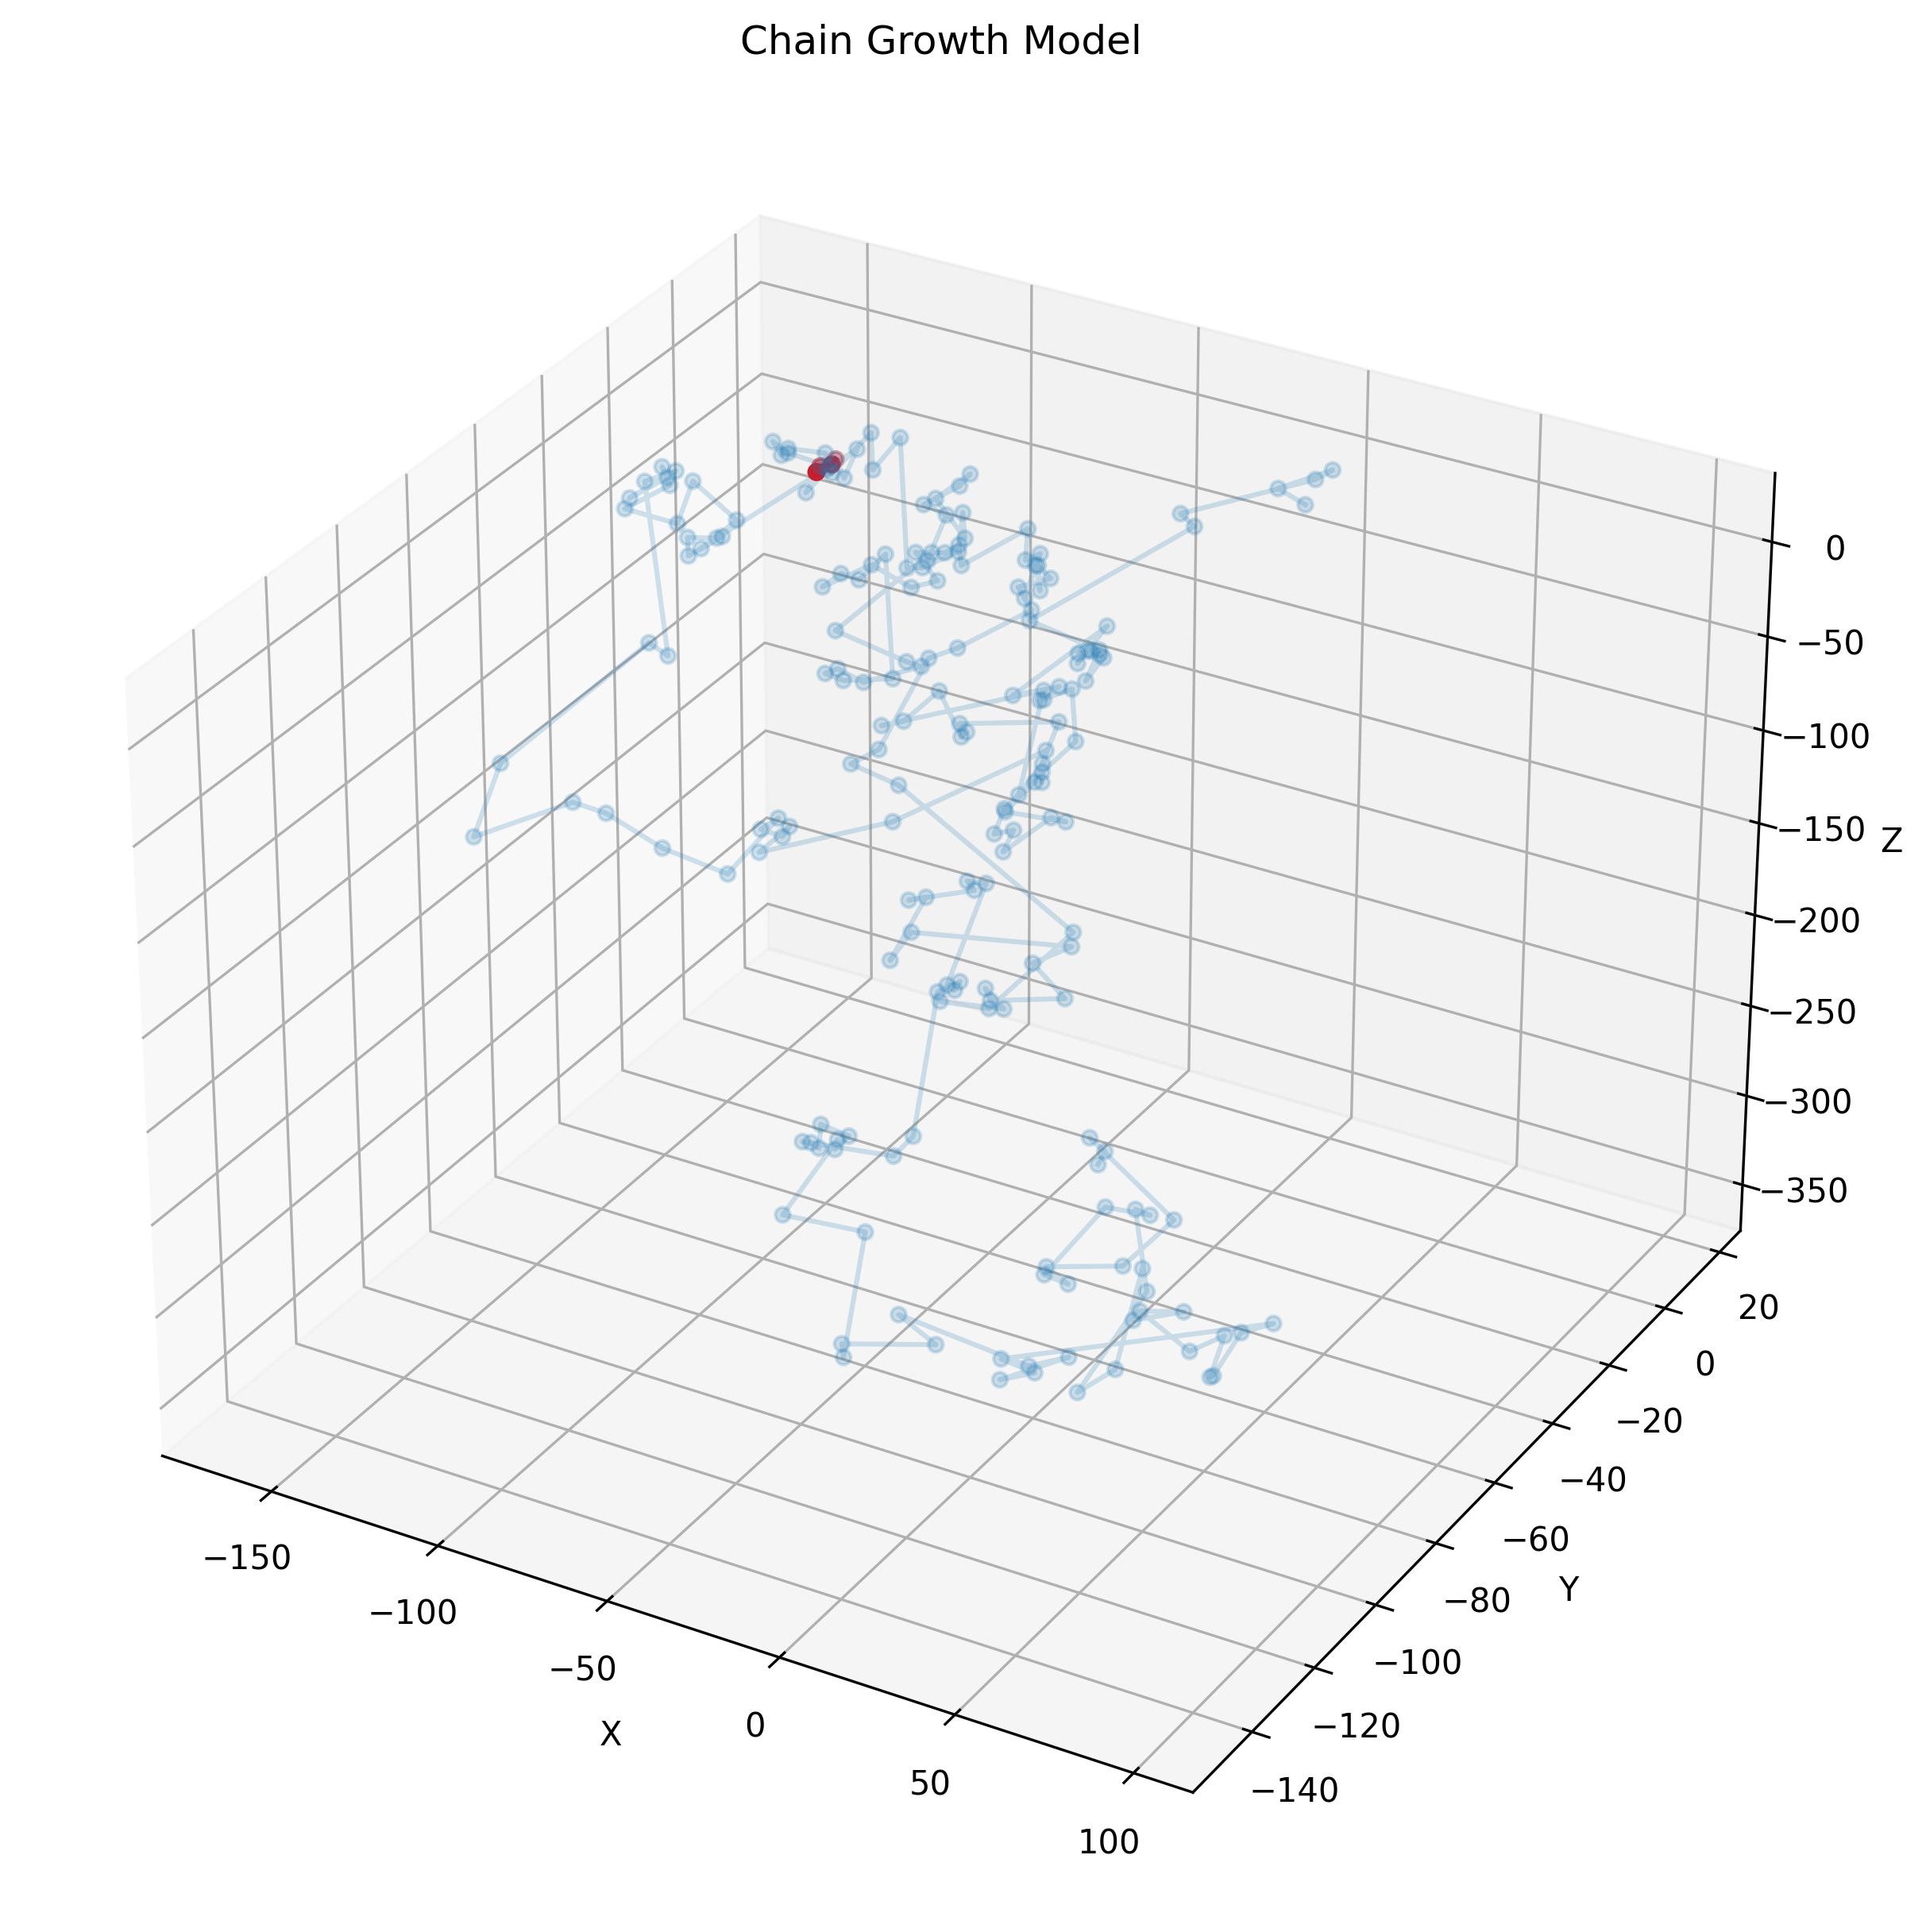

In [17]:
x = rn[:, 0]
y = rn[:, 1]
z = rn[:, 2]

fig = plt.figure(figsize=(10, 10), dpi=300)
ax = fig.add_subplot(111, projection='3d')

# Plot the points
ax.scatter(x, y, z, alpha=0.2)
ax.scatter(x[inds], y[inds], z[inds], color="Red")
ax.plot(x, y, z, alpha=0.2)
ax.plot(x[inds], y[inds], z[inds], color="Red")

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Chain Growth Model')

plt.show()

It appears that the introduction of sterics is breaking apart the clusters. The reasonable configuration observed in the chain growth model is more consistent with what is observed experimentally. Perhaps our MC moves are too large. Overlapping beads will accept any MC moves that resolves a steric clash. Therefore, large MC moves may be accepted even if they result in energetically unfavorable elastic energies.

#### Inspect Bond Lengths

Within clustered nucleosomes, compare the bond lengths generated by the chain growth model with those generated by the MC simulation.

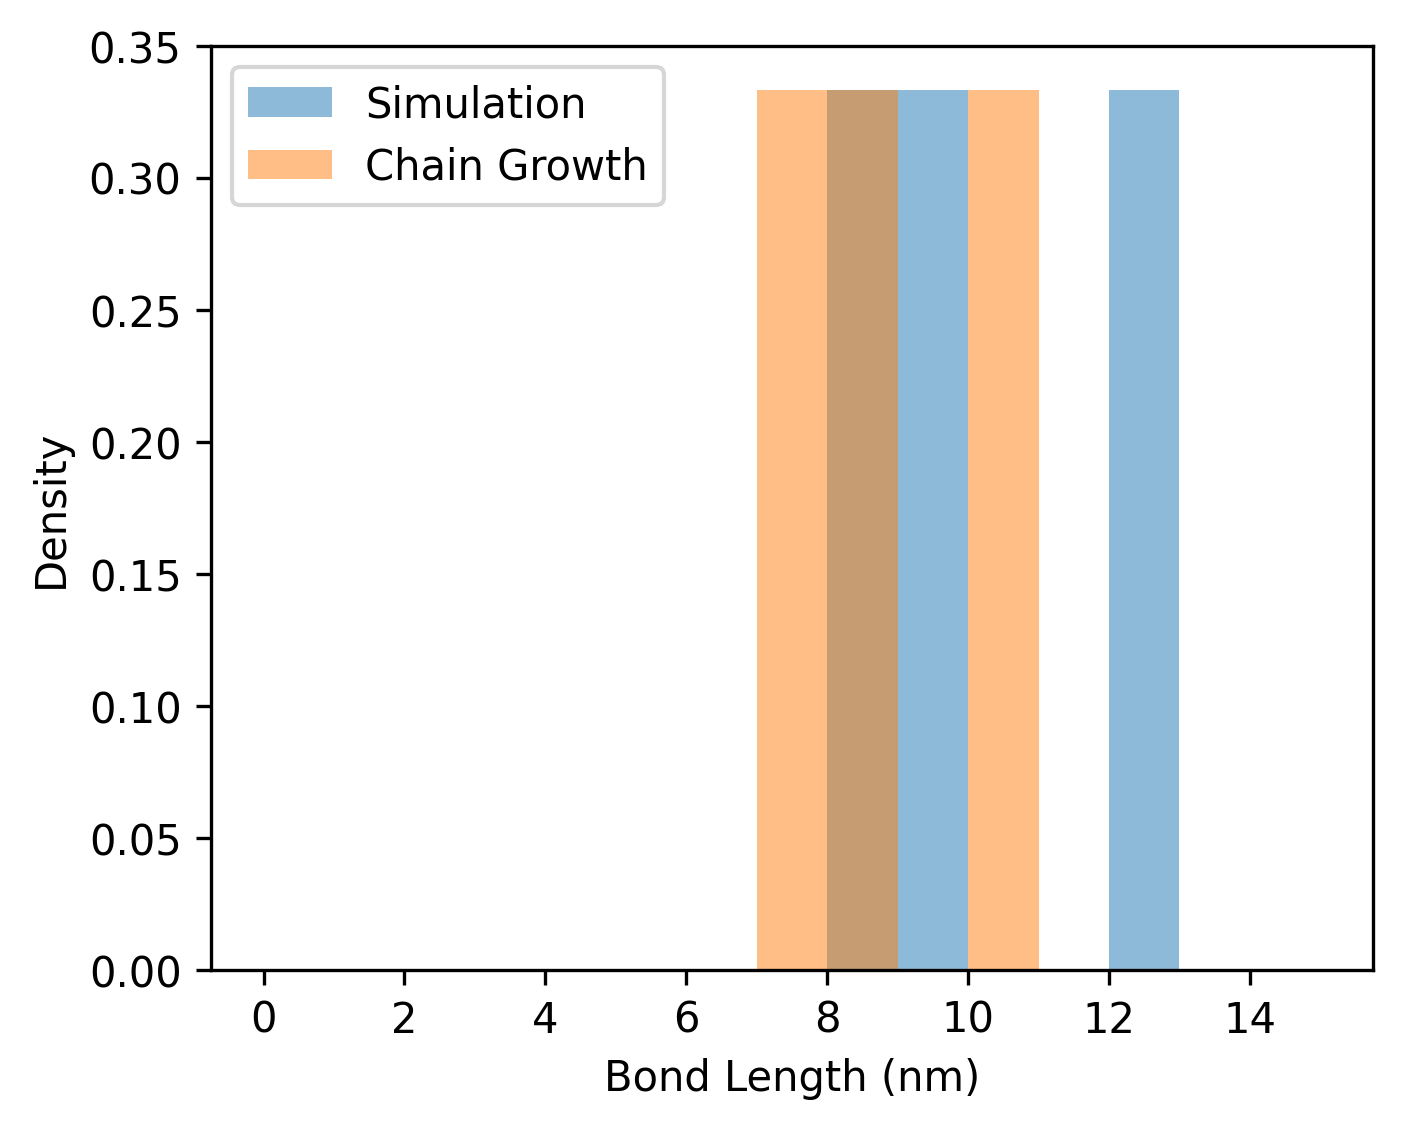

In [18]:
bond_lengths = np.linalg.norm(r[inds][1:] - r[inds][:-1], axis=1)
bond_lengths_chain_growth = np.linalg.norm(rn[inds][1:] - rn[inds][:-1], axis=1)
bin_edges = np.linspace(0, 15, 16)

plt.figure(figsize=(5,4), dpi=300)
plt.hist(bond_lengths, bins=bin_edges, alpha=0.5, density=True, label="Simulation")
plt.hist(bond_lengths_chain_growth, bins=bin_edges, alpha=0.5, density=True, label="Chain Growth")
plt.xlabel("Bond Length (nm)")
plt.ylabel("Density")
plt.legend()
plt.show()

Now compare bond lengths across the whole chromatin fiber.

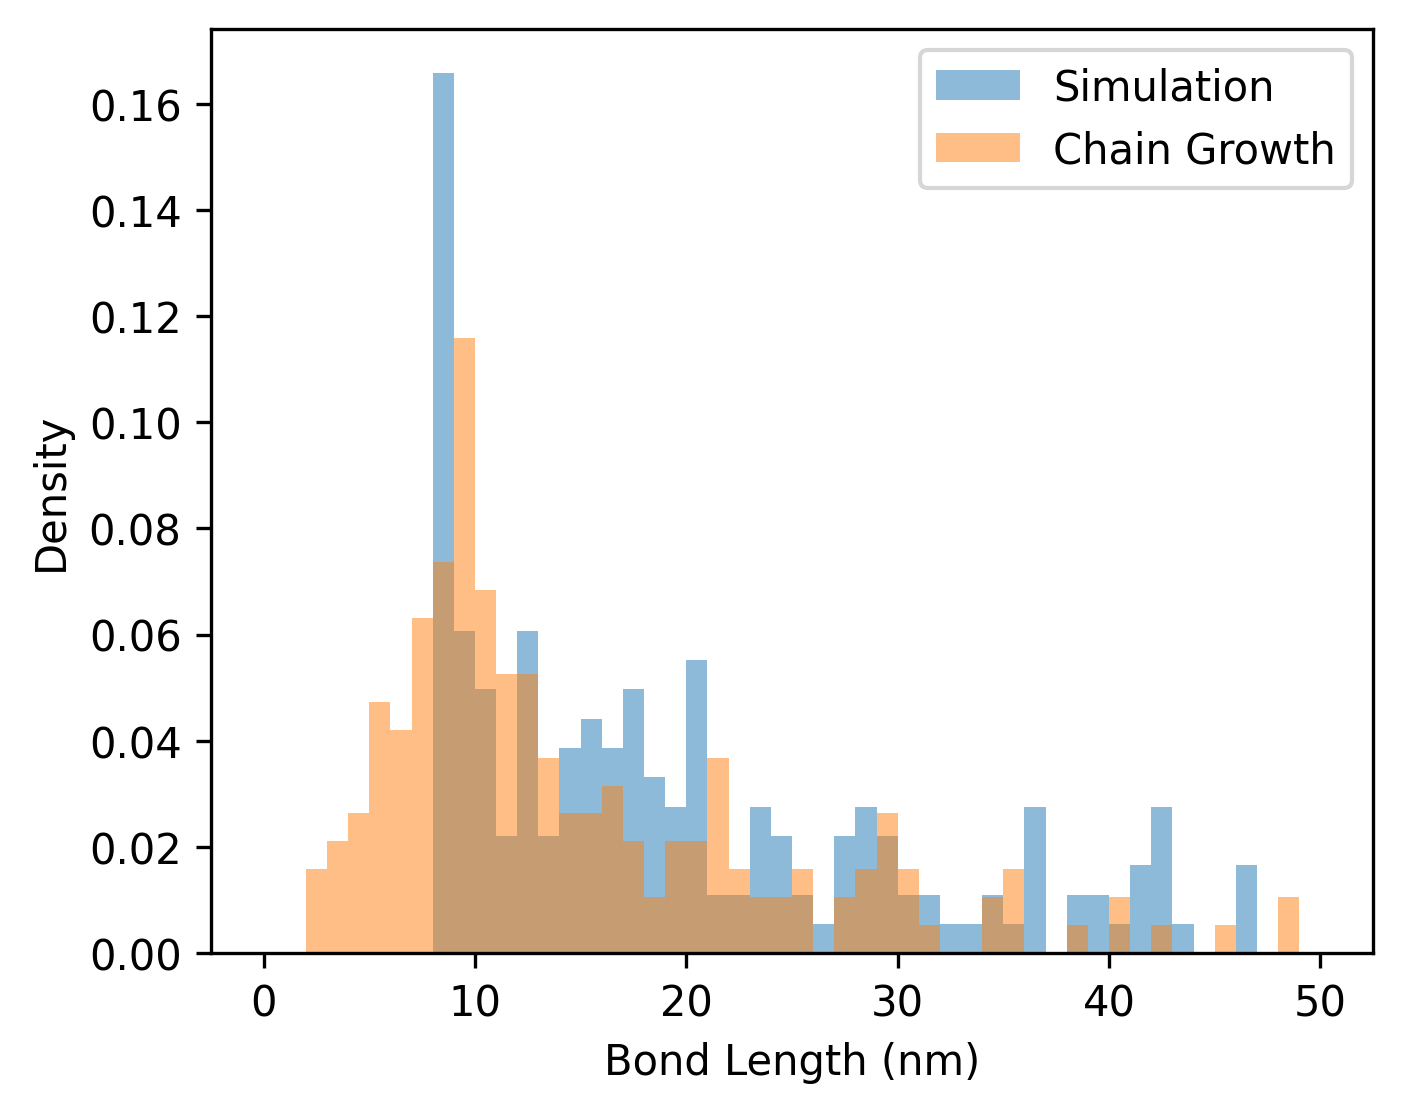

In [19]:
bond_lengths = np.linalg.norm(r[1:] - r[:-1], axis=1)
bond_lengths_chain_growth = np.linalg.norm(rn[1:] - rn[:-1], axis=1)
bin_edges = np.linspace(0, 50, 51)

plt.figure(figsize=(5,4), dpi=300)
plt.hist(bond_lengths, bins=bin_edges, alpha=0.5, density=True, label="Simulation")
plt.hist(bond_lengths_chain_growth, bins=bin_edges, alpha=0.5, density=True, label="Chain Growth")
plt.xlabel("Bond Length (nm)")
plt.ylabel("Density")
plt.legend()
plt.show()

The bond lengths appear to be roughly consistent between the simulation and the chain growth algorithm. The MC moves do not appear to completely disrupt bond lengths.

#### Inspect HP1 Binding

Is something strange happening with the binding of HP1 in the simulation? Perhaps if there is HP1 bound, there could be an error in the calculation of the binding energy.

In [20]:
for sim in sims:
    
    # Identify snapshots
    sim_dir = os.path.join(out_dir, sim)
    snaps = os.listdir(sim_dir)
    snaps = [snap for snap in snaps if snap.startswith("Chr") and snap.endswith(".csv")]
    snap_inds = [int(snap.split("-")[-1].split(".")[0]) for snap in snaps]
    snaps = [snap for _, snap in sorted(zip(snap_inds, snaps))]
    snap_inds = np.sort(snap_inds)
    latest_snap = snaps[np.argmax(snap_inds)]
    snaps_equilibrated = snaps[-n_equilibrate:]

    for snap in snaps_equilibrated:
        
        # Load configuration
        HP1 = pd.read_csv(os.path.join(sim_dir, snap), header=[0, 1], index_col=0)["states"].to_numpy()
        theta_HP1 = np.sum(HP1) / (2 * len(HP1))
        print(f"HP1 binding fraction: {theta_HP1}")

HP1 binding fraction: 0.0
HP1 binding fraction: 0.0
HP1 binding fraction: 0.0
HP1 binding fraction: 0.0


There is no HP1 bound to the chromatin fiber in the simulations. HP1 interactions do not appear to be the cause of the inconsistency.

#### How does Cluster Size Vary During a Simulation?

In [21]:
# Identify clusters
cluster_inds = identify_clusters(links)

# Load the radius of gyration for each cluster
Rg_all_snaps = {sim: [] for sim in sims}
all_snap_inds = {sim: None for sim in sims}

for cluster_id, inds in cluster_inds.items():
    for sim in sims:
    
        # Identify snapshots
        sim_dir = os.path.join(out_dir, sim)
        snaps = os.listdir(sim_dir)
        snaps = [snap for snap in snaps if snap.startswith("Chr") and snap.endswith(".csv")]
        snap_inds = [int(snap.split("-")[-1].split(".")[0]) for snap in snaps]
        snaps = [snap for _, snap in sorted(zip(snap_inds, snaps))]
        snap_inds = np.sort(snap_inds)
        
        # Insert the initial configuration into the list
        snaps.insert(0, "Chr")
        snap_inds += 1
        ind_to_add = np.array([0])
        snap_inds = np.concatenate((ind_to_add, snap_inds))
        all_snap_inds[sim] = snap_inds.copy()

        for snap in snaps:
            
            # Load configuration
            r = pd.read_csv(os.path.join(sim_dir, snap), header=[0, 1], index_col=0)["r"].to_numpy()

            # Generate cluster size
            Rg = minor_radius_of_gyration(r[cluster_inds[list(cluster_inds.keys())[0]]])

            # Store the cluster size
            Rg_all_snaps[sim].append(Rg)

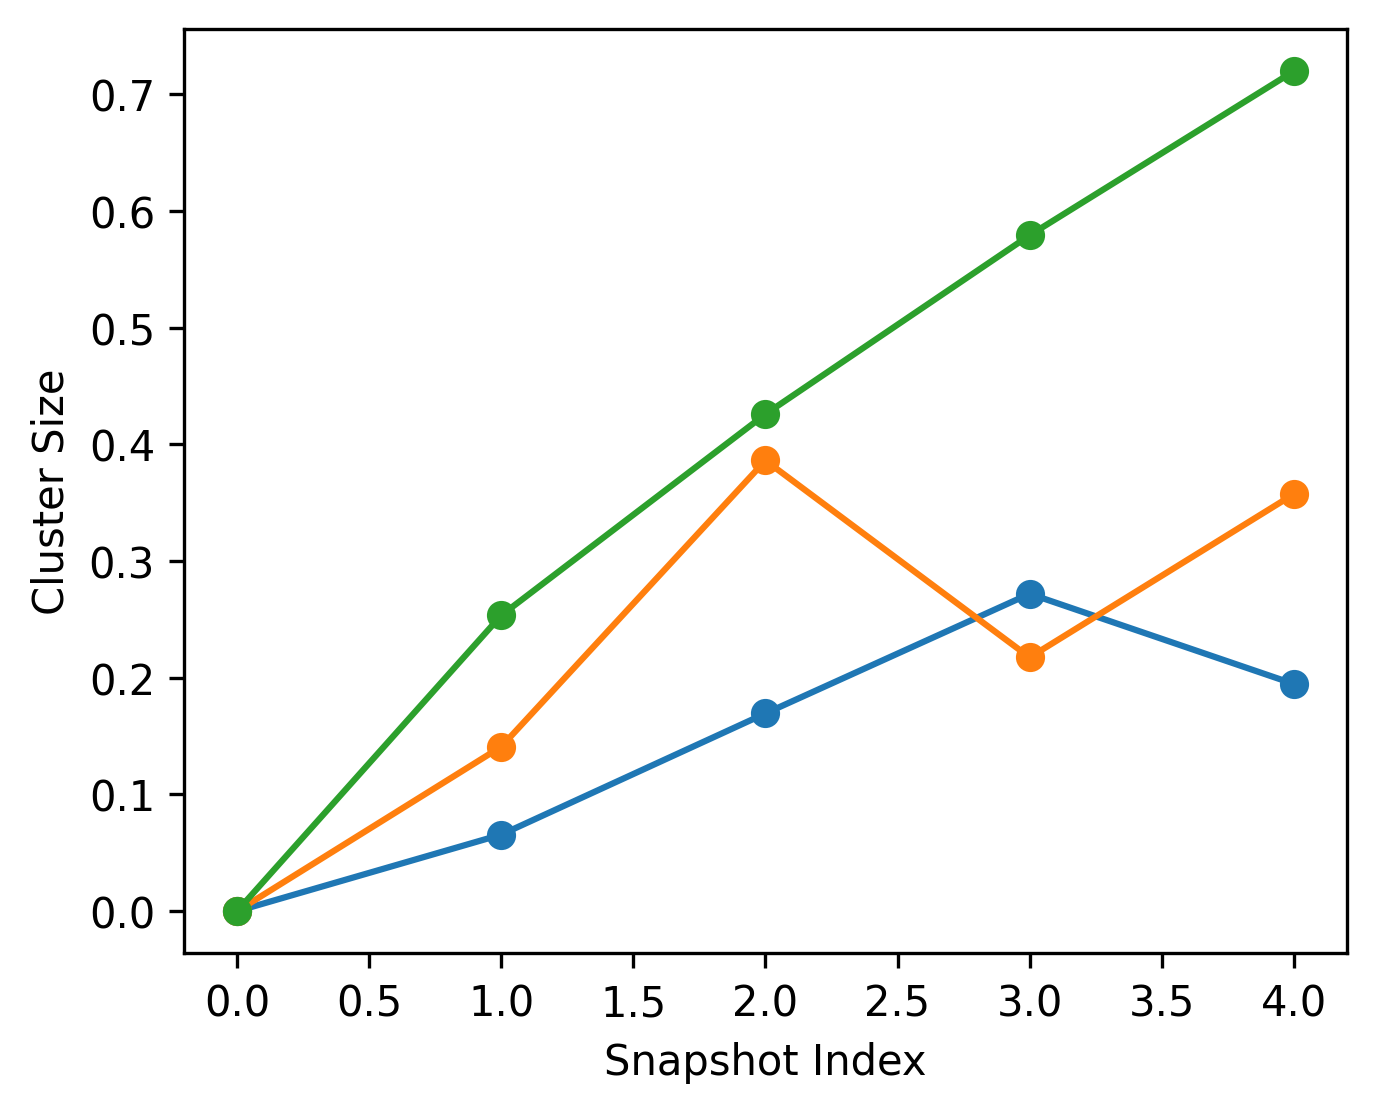

In [22]:
for sim in sims:
    plt.figure(figsize=(5,4), dpi=300)
    plt.plot(all_snap_inds[sim], Rg_all_snaps[sim], "o-")
    plt.xlabel("Snapshot Index")
    plt.ylabel("Cluster Size")
    plt.show()

Cluster size clearly increases over the course of a simulation, as steric clashes get resolved. 